### MCAのデータをフィッティング

データをインポートする関数などをロードする。

In [1]:
.L ../macros/importHist.C

ヒストグラムをMCAで得られたデータ(test.dat)から作成する。

In [2]:
auto h = importHist("test.dat");

size 1024


In [3]:
c = new TCanvas("can","",600,600);

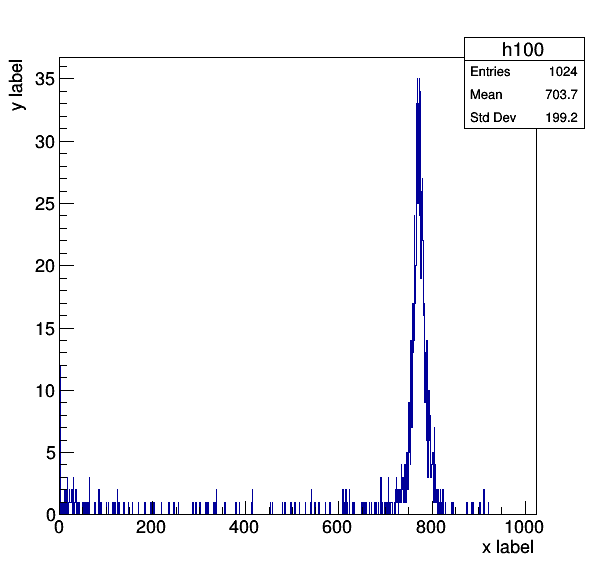

In [4]:
h->Draw();
c->Draw();

ビンが細かすぎるように思えるので、8chごとのビンに変更する。

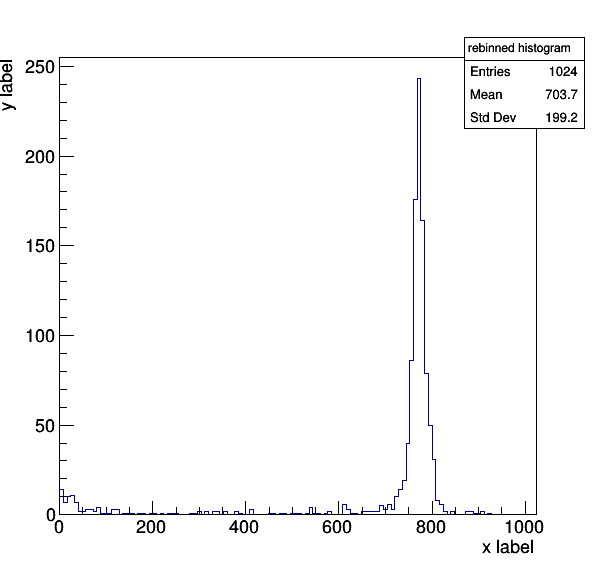

In [5]:
auto hRebin = rebin(h,8,"rebinned histogram");
hRebin->Draw();
c->Draw();

フィッティング関数の定義、ガウス分布を仮定する。  
ROOTではシステムでgaus関数が定義されているのでそれを使用する。  
gausは
$$
gaus(x) = A exp(-\frac{(x-m)^2}{2\sigma^2})
$$
gausnは規格化されたガウス関数で
$$
gausn(x) = \frac{Y}{\sqrt{2\pi}\sigma} exp(-\frac{(x-m)^2}{2\sigma^2})
$$
規格化されたガウス関数ではYがイベント数そのものに対応するためこちらを採用する。　


In [6]:
auto sg = new TF1("sg","gausn",600,1000);

おおよそのパラメータを初期値として入力。  
SetParameters()関数でY, m, $\sigma$の順でセットする。

In [7]:
sg->SetParameters(100,800,50);

フィッティング

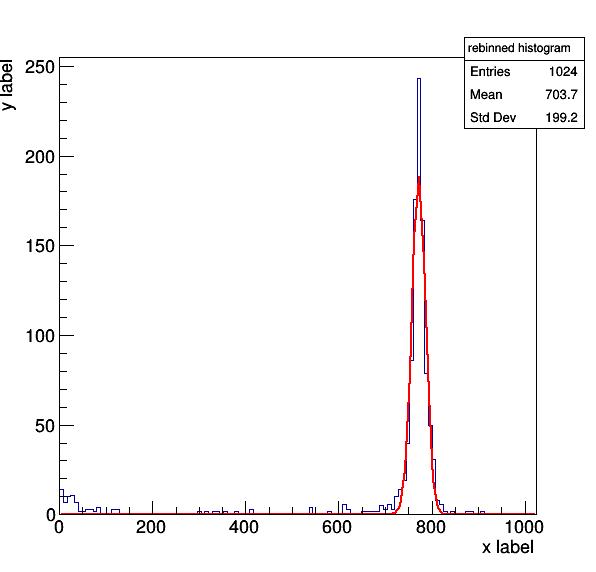

 FCN=223.859 FROM MIGRAD    STATUS=CONVERGED     181 CALLS         182 TOTAL
                     EDM=5.33717e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.98528e+03   2.36396e+02   1.72944e+00   3.40414e-07
   2  Mean         7.72225e+02   5.06087e-01   3.66747e-03   3.29651e-04
   3  Sigma        1.47993e+01   5.75204e-01   2.43771e-05  -8.73845e-02


In [8]:
hRebin->Fit("sg");
hRebin->Draw();
c->Draw();

フィッティングによりエントリー数を取得する。  
ここでヒストグラムは8channe/binなのでfittingで得られた値の1/8しなければならないことに注意。

In [7]:
double Y = sg->GetParameter(0)/8;
double dY = sg->GetParError(0)/8;
std::cout << Y << "+/-" << dY << std::endl;


873.16+/-29.5496


おまけ  
次にデータをdouble gaussianでfittingしてみる。　　
関数は以下の通り。  
中心が同じでシグマが異なる２つのガウス関数の和として定義する。  
par[4]はg1, g2の比を与えるものであり、$0 < {\rm par}[4] < 1$。  
したがって$\int (g1+g2) dx = 1$に規格化されている。

In [9]:
Double_t doubleGaus(Double_t *x, Double_t *par){
  double g1 = TMath::Gaus(x[0], par[1], par[2], kTRUE); 
  double g2 = TMath::Gaus(x[0], par[1], par[3], kTRUE); 
  return par[0]*(par[4]*g1+(1-par[4])*g2);
}



In [10]:
auto dg = new TF1("dg",doubleGaus,600,1000,5);
  dg->SetParameters(1000,770,15,50,0.8);
  hRebin->Fit("dg");

 FCN=172.582 FROM MIGRAD    STATUS=CONVERGED     166 CALLS         167 TOTAL
                     EDM=3.84262e-07    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.2 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.40562e+03   2.41757e+02  -4.18553e-01  -1.65908e-06
   2  p1           7.71651e+02   4.69808e-01  -5.04553e-04   7.11246e-04
   3  p2           2.27296e+01   2.38647e+00   1.27828e-02  -7.91593e-04
   4  p3           8.87223e+00   1.17305e+00   8.57026e-03  -7.80605e-04
   5  p4           4.77846e-01   1.04573e-01  -5.86051e-04  -1.76855e-02


In [11]:
Y = dg->GetParameter(0)/8;
dY = dg->GetParError(0)/8;
std::cout << Y << "+/-" << dY << std::endl;


925.702+/-30.2196


全ての結果を表示させる。


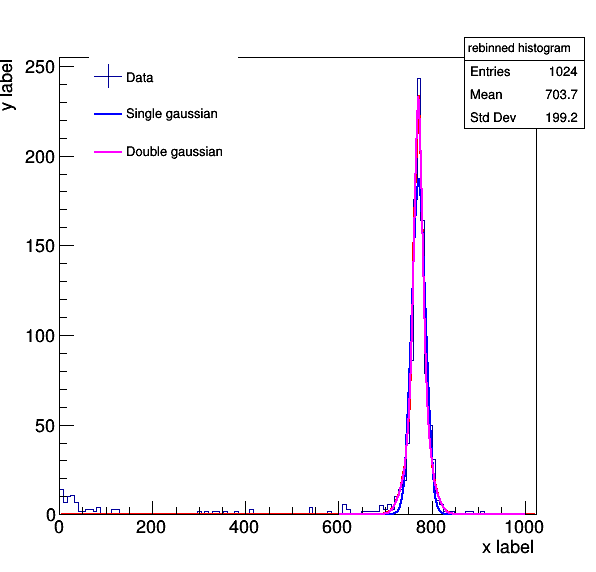

In [12]:
hRebin->Draw();
sg->SetLineColor(kBlue);
sg->Draw("same");
dg->SetLineColor(kMagenta);
dg->Draw("same");
auto leg = new TLegend(0.15,0.7,0.4,0.9,"","NDC");
leg->SetBorderSize(0);
leg->AddEntry(hRebin,"Data","lep");
leg->AddEntry(sg,"Single gaussian","l");
leg->AddEntry(dg,"Double gaussian","l");
leg->Draw();
c->Draw();
